In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import pickle
import random
from PIL import Image

In [2]:
def tensor_imshow(im_tensor,cannel):
    b,c,h,w=im_tensor.shape
    if c==1:
        plt.imshow(im_tensor.squeeze().detach().numpy())
    else:
        plt.imshow(im_tensor.squeeze().detach().numpy()[cannel,:])
        
def get_training_fragment(frag_size,im):
    h,w,c=im.shape
    n=random.randint(0,int(h/frag_size)-1)
    m=random.randint(0,int(w/frag_size)-1)
    
    shape=frag_size/4
    vt_h=math.ceil((h+1)/shape)
    vt_w=math.ceil((w+1)/shape)
    vt=np.zeros([vt_h,vt_w])
    vt_h_po=round((vt_h-1)*(n*frag_size/(h-1)+(n+1)*frag_size/(h-1))/2)
    vt_w_po=round((vt_w-1)*(m*frag_size/(w-1)+(m+1)*frag_size/(w-1))/2)
    vt[vt_h_po,vt_w_po]=1
    vt = np.float32(vt)
    vt=torch.from_numpy(vt.reshape(1,1,vt_h,vt_w))
    
    return im[n*frag_size:(n+1)*frag_size,m*frag_size:(m+1)*frag_size,:],vt
"""
def get_training_fragment(frag_size,im):
    h,w,c=im.shape
    n=random.randint(0,int(h-frag_size-1))
    m=random.randint(0,int(w-frag_size-1))
    
    vt_h=math.ceil((h+1)/8)
    vt_w=math.ceil((w+1)/8)
    vt=np.zeros([vt_h,vt_w])
    vt_h_po=round((vt_h-1)*(2*n+frag_size)/(2*(h-1)))
    vt_w_po=round((vt_w-1)*(2*m+frag_size)/(2*(w-1)))
    vt[vt_h_po,vt_w_po]=1
    vt = np.float32(vt)
    vt=torch.from_numpy(vt.reshape(1,1,vt_h,vt_w))
    
    return im[n:n+frag_size,m:m+frag_size,:],vt
"""
def img2tensor(im):
    im=np.array(im,dtype="float32")
    tensor_cv = torch.from_numpy(np.transpose(im, (2, 0, 1)))
    im_tensor=tensor_cv.unsqueeze(0)
    return im_tensor

def show_coordonnee(position_pred):
    map_corre=position_pred.squeeze().detach().numpy()
    h,w=map_corre.shape
    max_value=map_corre.max()
    coordonnee=np.where(map_corre==max_value)
    return coordonnee[0].mean()/h,coordonnee[1].mean()/w
    """
    if len(coordonnee[0])==1:
        h_=coordonnee[0][0]/h
        w_=coordonnee[1][0]/w
        return max_value,h_,w_
    else:
        return -1,-1,-1
    """

def test_fragment32_32(frag,seuillage):
    a=frag[:,:,0]+frag[:,:,1]+frag[:,:,2]
    mask = (a == 0)
    arr_new = a[mask]
    if arr_new.size/a.size<=(1-seuillage):
        return True
    else:
        return False
    
def save_net(file_path,net):
    pkl_file = open(file_path, 'wb')
    pickle.dump(net,pkl_file)
    pkl_file.close()
    
def load_net(file_path):   
    pkl_file = open(file_path, 'rb')
    net= pickle.load(pkl_file)
    pkl_file.close()
    return net

In [3]:
def kernel_add_ini(n,m):
    input_canal=int(n*m)
    output_canal=int(n/2)*int(m/2)
    for i in range(int(n/2)):
        for j in range(int(m/2)):
            kernel_add=np.zeros([1,input_canal],dtype='float32')
            kernel_add[0,i*2*m+j*2]=1
            kernel_add[0,i*2*m+j*2+1]=1
            kernel_add[0,(i*2+1)*m+j*2]=1
            kernel_add[0,(i*2+1)*m+j*2+1]=1
            if i==0 and j==0:
                add=torch.from_numpy(kernel_add.reshape(1,input_canal,1,1))
            else:
                add_=torch.from_numpy(kernel_add.reshape(1,input_canal,1,1))
                add=torch.cat((add,add_),0)
    return torch.nn.Parameter(add,requires_grad=False) 

def kernel_shift_ini(n,m):
    input_canal=int(n*m)
    output_canal=int(n*m)
    
    kernel_shift=torch.zeros([output_canal,input_canal,3,3])
    
    array_0=np.array([[1,0,0],[0,0,0],[0,0,0]],dtype='float32')
    array_1=np.array([[0,0,1],[0,0,0],[0,0,0]],dtype='float32')
    array_2=np.array([[0,0,0],[0,0,0],[1,0,0]],dtype='float32')
    array_3=np.array([[0,0,0],[0,0,0],[0,0,1]],dtype='float32')
    
    kernel_shift_0=torch.from_numpy(array_0)
    kernel_shift_1=torch.from_numpy(array_1)
    kernel_shift_2=torch.from_numpy(array_2)
    kernel_shift_3=torch.from_numpy(array_3)
    
    
    for i in range(n):
        for j in range(m):
            if i==0 and j==0:
                kernel_shift[0,0,:]=kernel_shift_0
            else:
                if i%2==0 and j%2==0:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_0
                if i%2==0 and j%2==1:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_1
                if i%2==1 and j%2==0:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_2
                if i%2==1 and j%2==1:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_3
                    
    return torch.nn.Parameter(kernel_shift,requires_grad=False) 

def get_patch(fragment,psize,n,m):
    return fragment[:,:,n*psize:(n+1)*psize,m*psize:(m+1)*psize]

def shift_1pixel(map_corr,num_patch):
    #num_patch:
    #          0 1
    #          2 3
    h,w=map_corr.shape
    map_shifted=torch.zeros([h,w])
    if num_patch==0:
        map_shifted[1:h,1:w]=map_corr[0:h-1,0:w-1]
    if num_patch==1:
        map_shifted[1:h,0:w-1]=map_corr[0:h-1,1:w]
    if num_patch==2:
        map_shifted[0:h-1,1:w]=map_corr[1:h,0:w-1]
    if num_patch==3:
        map_shifted[0:h-1,0:w-1]=map_corr[1:h,1:w]
        
    return map_shifted

def shift_map_corre(n,m,map_corre):
    b,c,h,w=map_corre.shape
    for i in range(n):
        for j in range(m):
            if i%2==0 and j%2==0:
                map_corre[0,i*m+j,:,:]=shift_1pixel(map_corre[0,i*m+j,:,:],0)
            if i%2==0 and j%2==1:
                map_corre[0,i*m+j,:,:]=shift_1pixel(map_corre[0,i*m+j,:,:],1)
            if i%2==1 and j%2==0:
                map_corre[0,i*m+j,:,:]=shift_1pixel(map_corre[0,i*m+j,:,:],2)
            if i%2==1 and j%2==1:
                map_corre[0,i*m+j,:,:]=shift_1pixel(map_corre[0,i*m+j,:,:],3)
    return map_corre

class Net(nn.Module):
    def __init__(self,frag_size,psize):
        super(Net, self).__init__()
       
        h_fr=frag_size
        w_fr=frag_size
        
        n=int(h_fr/psize) #n*m patches
        m=int(w_fr/psize)
        
        self.conv1 = nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1)
        #self.conv1.weight=ini()
        self.Relu = nn.ReLU(inplace=True)
        self.maxpooling=nn.MaxPool2d(3,stride=2, padding=1)
        
        self.shift1=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
        self.shift1.weight=kernel_shift_ini(n,m)
        self.add1 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
        self.add1.weight=kernel_add_ini(n,m)
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            self.shift2=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
            self.shift2.weight=kernel_shift_ini(n,m)
            self.add2 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
            self.add2.weight=kernel_add_ini(n,m)
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            self.shift3=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
            self.shift3.weight=kernel_shift_ini(n,m)
            self.add3 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
            self.add3.weight=kernel_add_ini(n,m)
        
        
    def get_descripteur(self,img,using_cuda):
        descripteur_img=self.Relu(self.conv1(img))
        b,c,h,w=descripteur_img.shape
        couche_constante=0.5*torch.ones([1,1,h,w])
        if using_cuda:
            couche_constante=couche_constante.cuda()
        descripteur_img=torch.cat((descripteur_img,couche_constante),1)
        descripteur_img_norm=descripteur_img/torch.norm(descripteur_img,dim=1)
        return descripteur_img_norm
    
    def forward(self,img,frag,using_cuda):
        psize=4
        
        descripteur_input1=self.get_descripteur(img,using_cuda)
        descripteur_input2=self.get_descripteur(frag,using_cuda)
        
        b,c,h,w=frag.shape
        n=int(h/psize)
        m=int(w/psize)
        
        for i in range(n):
            for j in range(m):
                if i==0 and j==0:
                    map_corre=F.conv2d(descripteur_input1,get_patch(descripteur_input2,psize,i,j),padding=2)
                else:
                    a=F.conv2d(descripteur_input1,get_patch(descripteur_input2,psize,i,j),padding=2)
                    map_corre=torch.cat((map_corre,a),1)
        #shift
        map_corre=self.maxpooling(map_corre)
        map_corre=self.shift1(map_corre)
        map_corre=self.add1(map_corre)
        
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            map_corre=self.maxpooling(map_corre)
            map_corre=self.shift2(map_corre)
            map_corre=self.add2(map_corre)
        
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            map_corre=self.maxpooling(map_corre)
            map_corre=self.shift3(map_corre)
            map_corre=self.add3(map_corre)
        
        
        b,c,h,w=map_corre.shape
        map_corre=map_corre/(map_corre.max())
        return map_corre

In [33]:
def run_net(net,img,frag,frag_size,using_cuda):
    h,w,c=frag.shape
    n=int(h/frag_size)
    m=int(w/frag_size)
    frag_list=[]
    for i in range(n):
        for j in range(m):
            frag_32=frag[i*frag_size:(i+1)*frag_size,j*frag_size:(j+1)*frag_size]
            if test_fragment32_32(frag_32,0.6):
                frag_list.append(frag_32)
    img_tensor=img2tensor(img)
    
    if using_cuda:
        img_tensor=img_tensor.cuda()
        
    coordonnee_list=[]
    for i in range(len(frag_list)):
        frag_tensor=img2tensor(frag_list[i])
        if using_cuda:
            frag_tensor=frag_tensor.cuda()
        res=net.forward(img_tensor,frag_tensor,using_cuda)
        if using_cuda:
            res=res.cpu()
        po_h,po_w=show_coordonnee(res)
        coordonnee_list.append([po_h,po_w])
    h_img,w_img,c=img.shape
    position=[]
    for i in range(len(coordonnee_list)):
        x=int(round(h_img*coordonnee_list[i][0]))
        y=int(round(w_img*coordonnee_list[i][1]))
        position.append([x,y])
    return position

In [19]:
if __name__=='__main__':
    
    frag_size=16
    psize=4
    using_cuda=True
    rotation=False
    net=Net(frag_size,psize)
    im_path="./fresque0.ppm"
    img_training=cv2.imread(im_path)
    itera=300
    ################training_net
    im_tensor=img2tensor(img_training)
    
    if using_cuda:
        net=net.cuda()
        im_tensor=im_tensor.cuda()
        
    optimizer = torch.optim.Adam(net.parameters())
    
    loss_func = torch.nn.MSELoss()
    loss_value=[]
    
    for i in range(itera):
        frag,vt=get_training_fragment(frag_size,img_training)
        if rotation:
            degre_rotation=random.uniform(-15,15)
            IM_frag=Image.fromarray(frag)
            frag=np.array(IM_frag.rotate(degre_rotation))
        frag_tensor=img2tensor(frag)
        if using_cuda:
            vt=vt.cuda()
            frag_tensor=frag_tensor.cuda()
        frag_pred=net.forward(im_tensor,frag_tensor,using_cuda)
        b,c,h,w=vt.shape
        err_=loss_func(vt,frag_pred)
                
        optimizer.zero_grad()
        err_.backward(retain_graph=True)
                    
        optimizer.step()
        loss_value.append(err_.tolist())
    
    

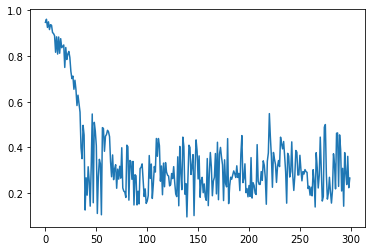

In [20]:
plt.plot(loss_value)

In [41]:
img_test=cv2.imread("./fresque1.ppm")
frag_test=cv2.imread("./frag_fresque1.png")

In [36]:
position=run_net(net,img_test,frag_test,16,using_cuda)
img_res=img_test
for i in range(len(position)):
    img_res[position[i][0]-3:position[i][0]+3,position[i][1]-3:position[i][1]+3,:]=0

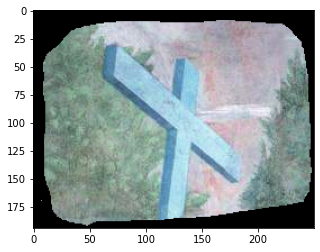

In [38]:
plt.imshow(frag_test)

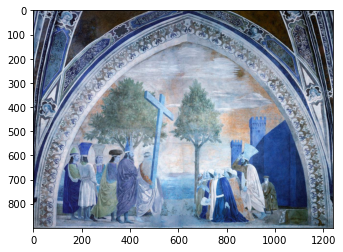

In [42]:
plt.imshow(img_test)

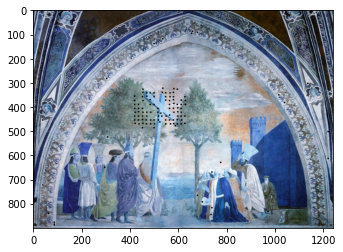

In [37]:
plt.imshow(img_res)

In [51]:
IMG_frag=Image.fromarray(frag_test)
frag_test=np.array(IMG_frag.rotate(15))
img_test=cv2.imread("./divide_fresque1.png")

In [52]:
res=run_net(net,img_test,frag_test,True)
for i in range(len(res)):
    img_test[res[i][0]-5:res[i][0]+5,res[i][1]-5:res[i][1]+5,:]=0

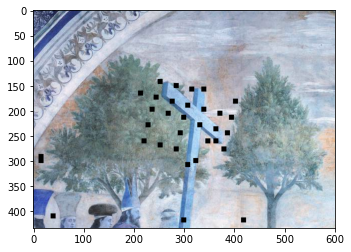

In [44]:
plt.imshow(img_test)

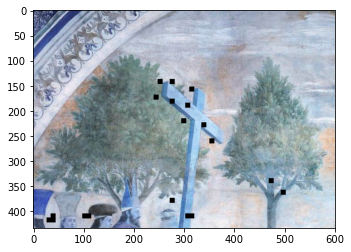

In [53]:
plt.imshow(img_test)